# __DEFOCUS SIMULATIONS AND IMAGE RESTORATION TECHNIQUES__

In [1]:
# import necessary libraries and functions
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2 as cv
from scipy.fftpack import fft2, fftshift, ifft2, ifftshift
from skimage.measure import compare_mse
from scipy.special import j1 as bessel1D

import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In the computer vision community, the standard way of simulating the defocus blur is by convolving the original image with a blur kernel. This kernel is usually chosen to be; 
- Gaussian,
- 2D Bessel kernel (i.e., Airy Disk), or 
- A simple disk kernel.

For all of these kernels, the amount of the blur is controlled by the size of the kernel. An implemetation of these blur simulations:

In [2]:
class Defocuser(object):
    def __init__(self, radius, type_ = 'disk', noise_poisson = 1e-3, noise_gauss = 1e-3):
        self.radius = radius
        self.type = type_
        self.poisson_val = noise_poisson
        self.gauss_noise_std = noise_gauss
        
        sizeX = 512
        sizeY = 512
        x,y = np.mgrid[-sizeY/2:sizeY/2, -sizeX/2:sizeX/2]
        
        if self.type == 'disk':
            self.kernel = (np.sqrt(x**2 + y**2) < self.radius).astype(float)
            self.kernel /= self.kernel.sum()
            
        elif self.type == 'airy':
            self.radius *= 3.5
            r = np.sqrt(x**2 + y**2)
            X = 2 * np.pi * r / self.radius
            airy_disk = (2 * bessel1D(X) / X)**2
            # take care of inf and nan values
            airy_disk[np.isinf(airy_disk)] = 1
            airy_disk[np.isnan(airy_disk)] = 1
            # normalize
            airy_disk /= np.sum(airy_disk)
            self.kernel = airy_disk
        
        elif self.type == 'gauss':
            gaussian = np.exp(-(x**2/float(self.radius**2)+y**2/float(self.radius**2)))
            gaussian /= np.sum(gaussian)
            self.kernel = gaussian
            
    def apply(self, image):
        smoothed = cv.filter2D(image,-1, self.kernel)
        # For color images, comment the preceding line above and uncomment the following line 
        # smoothed = cv.merge([cv.filter2D(cv.split(image)[i],-1, self.kernel) for i in range(3)])
        return smoothed
    
    # We may want to add noise to our final blurred images, too
    def applyNoise(self, image):
        # Remember that Poisson noise is not additive, it scales with the image intensity
        noisy = np.random.poisson(image / self.poisson_val) * self.poisson_val
        # Assume zero mean noise
        gauss_mean = 0.0
        gauss_noise = np.random.normal(gauss_mean, self.gauss_noise_std / 255.0, image.shape)
        noisy += gauss_noise
        return noisy
        
    def applyWithNoise(self, image):
        smoothed = cv.filter2D(image,-1, self.kernel)
        # For color images, comment the preceding line above and uncomment the following line 
        # smoothed = cv.merge([cv.filter2D(cv.split(image)[i],-1, self.kernel) for i in range(3)])
        return self.applyNoise(smoothed)

There are two things I want to note here:
- I could not find much in the way of rigorous justification regarding the choice of these kernels. Some authors suggest a ray tracing approach and claim that an object point "spreads" all of its energy equally to the pixels inside the circle of confusion (circles in the screen shown below), thus a Disk kernel is a better simulator of defocus.

<img src="Cirles_of_confusion_lens_diagram.png">
- I have also added noise to our simulator to make it a little bit more realistic. Poisson noise is to simulate the photon shot noise and an additive Gaussian noise is used as a generic noise model.

For testing our simulator, we are starting by reading an image into the memory. This image will be our "input object", and then we are going to apply the defocus(!):

In [3]:
# read an image, convert to grayscale and floating point (in range 0-1)
image = cv.imread('Lena.png')
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
# double check the image attributes
print('Image size is', image.shape, 'and data type is', image.dtype)

Image size is (512, 512) and data type is float64


The root mse between the original and disk-blurred (without noise) image is 0.06961651852907846


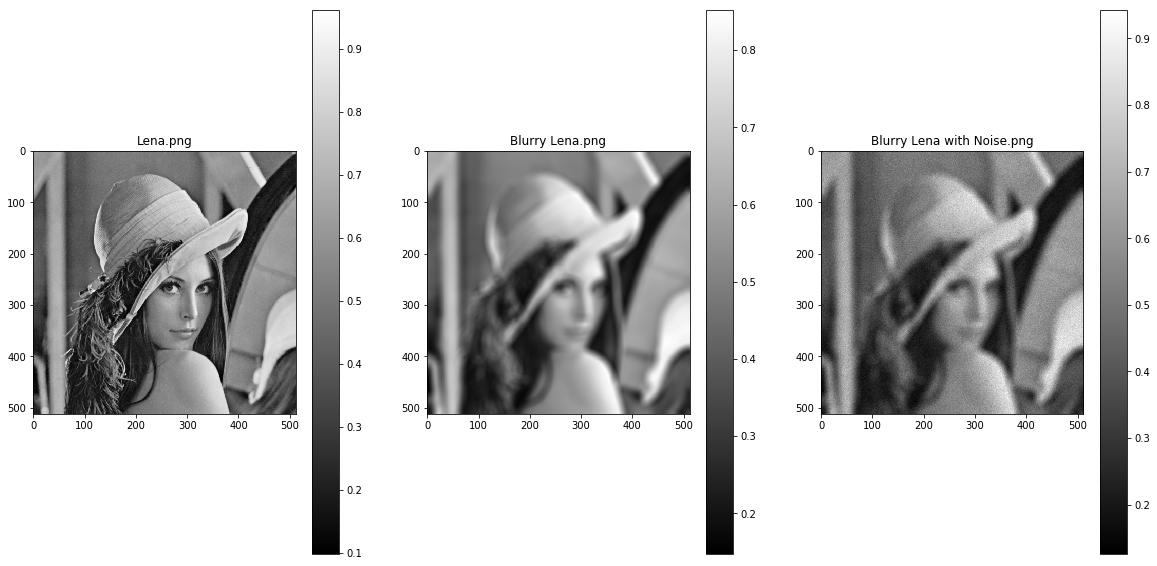

In [4]:
defocus = Defocuser(10, type_='disk')
blurred = defocus.apply(image)
blurredWithNoise = defocus.applyWithNoise(image)

fig = plt.figure(figsize=(20,10))
#  show the original
fig.add_subplot(131)
ax = plt.imshow(image, cmap='gray')
plt.colorbar(ax)
plt.title("Lena.png");
#  show blurred image
fig.add_subplot(132)
ax = plt.imshow(blurred, cmap='gray')
plt.colorbar(ax)
plt.title("Blurry Lena.png");
#  show blurred image with noise
fig.add_subplot(133)
ax = plt.imshow(blurredWithNoise, cmap='gray')
plt.colorbar(ax)
plt.title("Blurry Lena with Noise.png")

print('The root mse between the original and disk-blurred (without noise) image is {}'.format(np.sqrt(compare_mse(np.abs(image), np.abs(blurred)))))

## **Optical Image Formation**

Our optical system is just an aperture, just like a pinhole camera. This is the function to create that aperture.

In [5]:
def createPupil(L, numPixels, pupilRadius):
    # Create a mask, where we have 1s inside a circular aperture and 0s outside
    W, H            = np.meshgrid(np.linspace(-L/2, L/2, num=numPixels), np.linspace(-L/2, L/2, num=numPixels))
    pupilMask       = np.sqrt(W**2 + H**2) <= pupilRadius

    # Not necessary but for completeness: Our aperture is just a hole, it does not change the phase of the wavefront
    pupil = pupilMask + 0j
    # Calculate the intensity
    I_spatial = (np.abs(pupil)**2).sum()*dx*dx
    # normalize it so that its total power is 1
    pupil = pupil * np.sqrt(1 / I_spatial)
    
    return pupil

### Fourier Transform Functions and Convolution Theorem

Discrete Fourier Transorm operators exist in a lot of libraries, but to have physically meaningful values, we must remember to scale the _fft2_ and _ifft2_ outputs with respective "sampling periods" in spatial and frequency domains. 

These multiplications tend to get confusing when you chain a lot of operators, so let's start with our Fourier Transform implementations such that the scaling is taken care of inside our implementation.

A rule of thumb for shifting:
- _fft2_ and _ifft2_ always expects the origin at the beginning of the array
- _fftshift_ takes the output of an _fft2_ and makes it readable (i.e. shifts the origin to the center). So we always write it like _fftshift_ ( _fft2_ (.))

In [6]:
def ft2(g, dx):
    G = fftshift(fft2(ifftshift(g))) * dx**2
    return G

def ift2(G, df):
    # Instead of passing numPixels as a parameter, just read it from the input size
    numPixels = G.shape[0]
    # Note that (df*numPixels) is equal to 1/dx
    g = fftshift(ifft2(ifftshift(G))) * (df*numPixels)**2
    return g

# While we are at it, let's also implement the convolution theorem
def conv2(g1, g2, dx):
    # Switch to frequency domain and multiply, a.k.a. convolution theorem
    G1 = ft2(g1, dx)
    G2 = ft2(g2, dx)
    G_out = G1*G2
    # Instead of passing numPixels as a parameter, just read it from the input size
    numPixels = g1.shape[0]    
    # Switch back to the spatial domain
    # Note that 1/(numPixels*dx) is equal to df (or 1/L)
    g_out = ift2(G_out, 1/(numPixels*dx))
    return g_out

#### Visualizing the Point Spread Function

Set the parameters of our simulation:

In [7]:
lambda_     = 0.68e-6              # wavelength
k           = 2*np.pi/lambda_
numPixels   = 512                  # Number of pixels in the camera
L           = 512e-6               # Size of the calculation plane
pixelSize   = L/numPixels

pupilRadius = 10e-6                

Create our coordinate system and calculate the sampling periods in spatial & frequency domains:

In [8]:
# Forget the y coordinate, just work with square images so that y=x

# Create the spatial domain coordinates
x = np.arange(-(numPixels/2), (numPixels/2))*pixelSize # double check this against the MATLAB code!!!

# Sampling period, i.e., distance between two sample points in the spatial domain
dx = x[1] - x[0]
# Sampling period BUT in the frequency domain, ~ equal to 1/L
df = 1/(numPixels*dx)     

# Create the frequency domain coordinates
fx = np.arange(-(numPixels/2), (numPixels/2))*df

Create our pupil function. This is simulating the aperture of the optical system:

In [9]:
pupil = createPupil(L, numPixels, pupilRadius)

Using our Fourier Transform function, create the psf of the pupil:

In [10]:
# Take the Fourier Transform
csf = ft2(pupil, dx)  # This is the "coherent spread function" or "amplitude spread function", i.e., for coherent imaging
psf = np.abs(csf)**2  # This is the "point spread function", i.e., for incoherent imaging

Not necessary, but compare the total intensities to see whether the power is conserved:

In [11]:
# Calculate the intensity
I_spatial = (np.abs(pupil)**2).sum()*dx*dx
#normedPupil = pupil * np.sqrt(1 / I)

# Calculate the intensity
I_frequency = psf.sum()*df*df

if np.allclose(I_frequency, I_spatial, atol=1e-3):
    print('Power is conserved (check that {} ~= {})'.format(I_frequency,I_spatial))
else:
    print('Power is NOT conserved (check that {} ~= {})'.format(I_frequency,I_spatial))

Power is conserved (check that 0.9999999999999998 ~= 1.0)


Plot the pupil and its PSF:

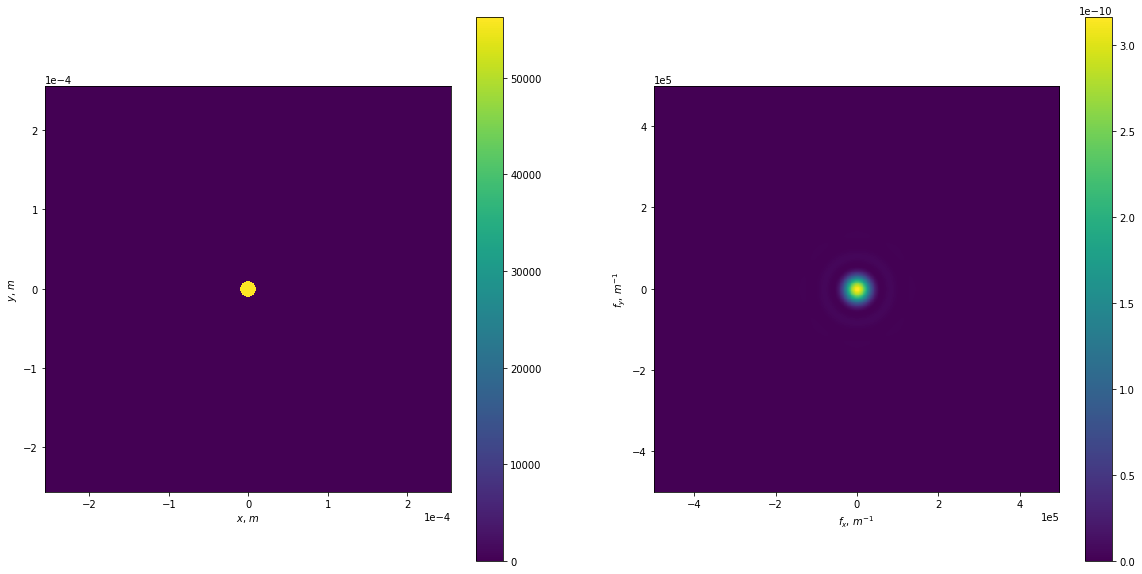

In [12]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(121)
# Show the pupil
ax = plt.imshow(np.abs(pupil), extent = [x[0], x[-1], x[0], x[-1]])
plt.colorbar(ax)
plt.ticklabel_format(style='sci',scilimits=(-2,2))
plt.xlabel('$x$, $m$')
plt.ylabel('$y$, $m$');
fig.add_subplot(122)
# Show the psf
img = plt.imshow(psf, extent = [fx[0], fx[-1], fx[0], fx[-1]])
plt.ticklabel_format(style='sci',scilimits=(-2,2))
plt.colorbar(img)
plt.xlabel('$f_x$, $m^{-1}$')
plt.ylabel('$f_y$, $m^{-1}$');
#plt.gca().set_xlim((-1e4, 1e4))
#plt.gca().set_ylim((-1e4, 1e4));

## Imaging using a PSF

Set the optical system parameters:

In [13]:
lambda_     = 1e-6              # wavelength
k           = 2*np.pi/lambda_
numPixels   = 512               # Number of pixels in the camera
L           = 0.1               # Size of the calculation plane
pixelSize   = L/numPixels


##########################################################################
##########################################################################
#####################play with this value#################################

# Selecte a large aperture to image the object "perfectly"
pupilRadius = 0.01       

##########################################################################
##########################################################################

Create the coordinates:

In [14]:
# Forget the y coordinate, just work with square images

# Create the spatial domain coordinates
x = np.arange(-(numPixels/2), (numPixels/2))*pixelSize # double check this against the MATLAB code!!!

# Sampling period, i.e., distance between two sample points in the spatial domain
dx = x[1] - x[0]
# Sampling period BUT in the frequency domain, ~ equal to 1/L
df = 1/(numPixels*dx)     

# Create the frequency domain coordinates
fx = np.arange(-(numPixels/2), (numPixels/2))*df

Do the imaging:

In [15]:
pupil = createPupil(L, numPixels, pupilRadius)
h = ft2(pupil, dx)
psf = np.abs(h)**2

# One way of normalization is by normalizing to make the center point equal to 1
#PSF /= PSF[numPixels//2,numPixels//2]

# Another way is so that the total energy of the OTF is equal to 1 so that the brightness values remain reasonable
#PSF /= np.sum(PSF)

# Or we could "normalize" by the correct sampling period selection (here it is df)
imaged = conv2(image, psf, df)
# The coherent imaging way would be like this:
# imaged = conv2(image, h, 1)

The object (i.e., the input image) and image are NOT same.
Their root mse is 0.045867652294291836


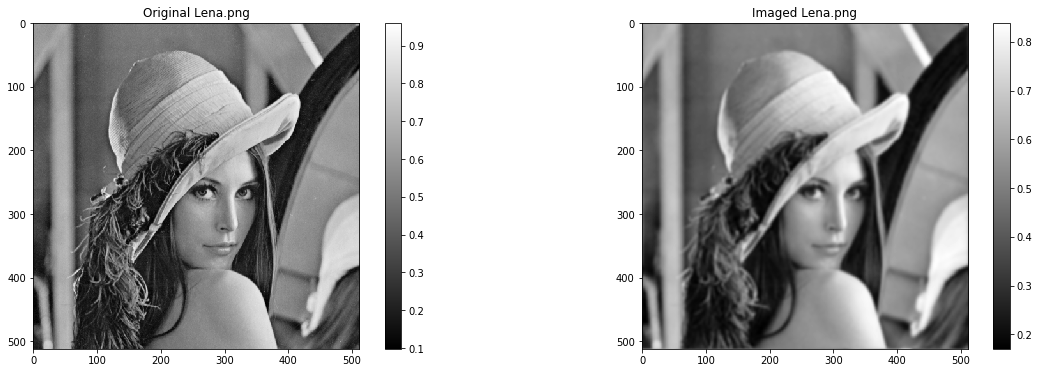

In [16]:
#  show the image
fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
ax = plt.imshow(np.abs(image), cmap='gray')
plt.title("Original Lena.png")
plt.colorbar(ax)
fig.add_subplot(122)
ax = plt.imshow(np.abs(imaged), cmap='gray')
plt.title("Imaged Lena.png")
plt.colorbar(ax)

if np.allclose(imaged, image, atol=1e-5):
    print('The object (i.e., the input image) and image are the same.')
    print('Their root mse error is {}'.format(np.sqrt(compare_mse(np.abs(image), np.abs(imaged)))))
else:
    print('The object (i.e., the input image) and image are NOT same.')
    print('Their root mse is {}'.format(np.sqrt(compare_mse(np.abs(image), np.abs(imaged)))))

We have have created a blurred image, but is this a simulation for defocus? No, this blur is stemming from the loss of high frequency components (fine details, like sharp edges and corners) in the image. This blur is happening because our pupil function is "cutting off" the high frequencies - a low pass filter.

In fact, what we have done is the same thing as convolving with an Airy Disk - we have just arrived at it computationally.

## A Better Defocusing Simulation

In their 2003 and 2004 papers ([Phase retrieval for high-numerical-aperture optical systems](https://pdfs.semanticscholar.org/7080/134549f2185cd0c41ed6b7d8eddcd60a95cd.pdf) and [Phase-retrieved pupil functions in wide-field fluorescence
microscopy](https://pdfs.semanticscholar.org/7080/134549f2185cd0c41ed6b7d8eddcd60a95cd.pdf) respectively) Hanser et al. provide an exact defocus model for both wide and small numerical aperture systems. They arrive at this by parametrizing a 3D psf-otf pair on the z axis, that is, they find the 2D psf slices at each z value.

In this model, we add a phase term to the pupil function. We can experiment with different z values and see how the phase term varies with it: 

In [17]:
FX,FY = np.meshgrid(fx,fx)

z = .2
phaseAngle   = 1j * z * np.sqrt((2*np.pi / lambda_)**2 - FX**2 - FY**2)
defocusTerm  = np.exp(phaseAngle)

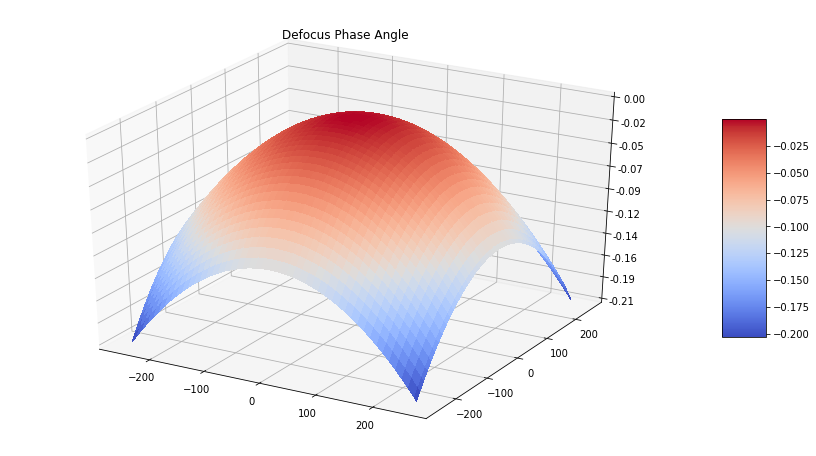

In [18]:
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')

# Plotting example: https://matplotlib.org/examples/mplot3d/surface3d_demo.html
pixelGridX, pixelGridY = np.meshgrid(np.arange(-(numPixels/2), (numPixels/2)),np.arange(-(numPixels/2), (numPixels/2)))
surf = ax.plot_surface(pixelGridX,pixelGridY, np.angle(defocusTerm), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5);
ax.set_title("Defocus Phase Angle");

Now, we apply a reasonable amount of defocus to a system with a very large aperture. We select the aperture such that without defocus, the "object" would be imaged perfectly - a convolution with a kernel that has a single 1 with the rest of the elements as 0, i.e. an identity operation:

The object (i.e., the input image) and image are NOT same.
Their root mse is 0.06962643693148389


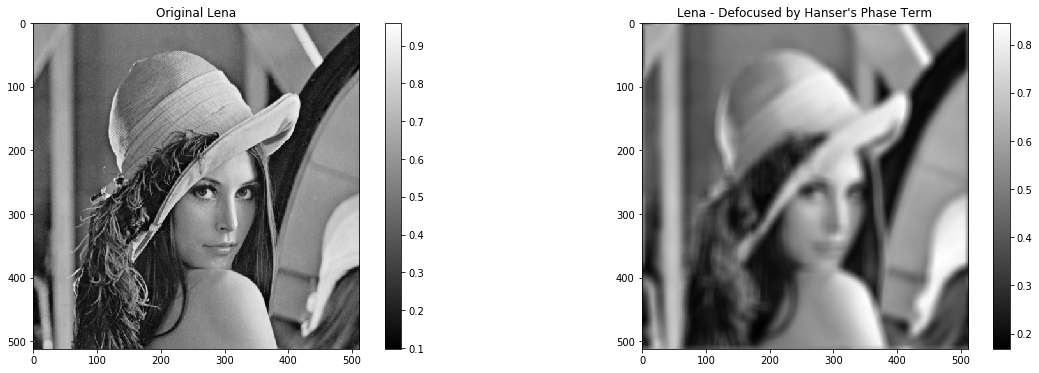

In [19]:
pupilRadius = 0.1

z = .63663
phaseAngle   = 1j * z * 2*np.pi * np.sqrt((1 / lambda_)**2 - FX**2 - FY**2)
defocusTerm  = np.exp(phaseAngle)

pupil = createPupil(L, numPixels, pupilRadius)
h = ft2(pupil* defocusTerm, dx)
psf = np.abs(h)**2

imageHanserDefocus = conv2(image, psf, df)
#  show the image
fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
ax = plt.imshow(np.abs(image), cmap='gray')
plt.title("Original Lena")
plt.colorbar(ax)
fig.add_subplot(122)
ax = plt.imshow(np.abs(imageHanserDefocus), cmap='gray')
plt.title("Lena - Defocused by Hanser's Phase Term")
plt.colorbar(ax)

if np.allclose(imaged, image, atol=1e-5):
    print('The object (i.e., the input image) and image are the same.')
    print('Their root mse error is {}'.format(np.sqrt(compare_mse(np.abs(image), np.abs(imageHanserDefocus)))))
else:
    print('The object (i.e., the input image) and image are NOT same.')
    print('Their root mse is {}'.format(np.sqrt(compare_mse(np.abs(image), np.abs(imageHanserDefocus)))))

## A More Flexible Approach to Aberrations

Another approach to modeling optical aberrations, including defocus, is to use Zernike polynomials, noted as $Z^m_n(r,\theta)$. The basic idea of adding a phase term to the pupil function is the same. However, we can select different polynomials to model various different aberrations by the selection of $n$ and $m$. For defocus aberration, $n=2, m=0$.

Here is an implementation of Zernike polynomials in Python, adapted from the MATLAB (Listing 5.1, page 69) script found in the book [Numerical Simulation of Optical Wave Propagation with Examples in MATLAB](http://spie.org/Publications/Book/866274?SSO=1) by Schimdt, J.D.:

In [20]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def zrf(n,m,r):
    R = 0
    for s in range(0,(n-m)//2):
        num = (-1)**s * np.math.factorial(n-s)
        denom = np.math.factorial(s) * np.math.factorial((n+m)/2-s) * np.math.factorial((n-m)/2-s)
        R += num / denom * r**(n-2*s)
    return R

def zernike(n,m,r, theta):
    if m==0:
        Z = np.sqrt(n+1)*zrf(n,0,r);
    else:
        if i%2 == 0:
            Z = np.sqrt(2*(n+1))*zrf(n,m,r)*np.cos(m*theta)
        else:
            Z = np.sqrt(2*(n+1))*zrf(n,m,r)*np.sin(m*theta)
    return Z

Now we apply $Z_2^0$ to our optical system. We can "tune" the amount of defocus by simple scaling:

The object (i.e., the input image) and image are NOT same.
Their root mse is 0.06962649073983274


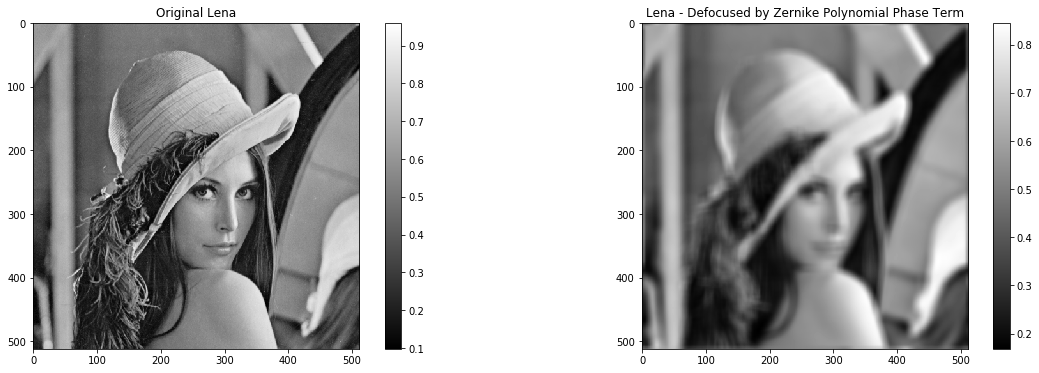

In [21]:
pupilRadius = 0.1
z = 0.60221

X,Y = np.meshgrid(x,x)
r, theta = cart2pol(X, Y)
W = z * zernike(2, 0, 2*r/pupilRadius, theta)
defocusTerm = np.exp(1j * 2*np.pi * W)

pupil = createPupil(L, numPixels, pupilRadius)
h = ft2(pupil* defocusTerm, dx)
psf = np.abs(h)**2


imageZernikeDefocus = conv2(image, psf, df)
#  show the image
fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
ax = plt.imshow(np.abs(image), cmap='gray')
plt.title("Original Lena")
plt.colorbar(ax)
fig.add_subplot(122)
ax = plt.imshow(np.abs(imageZernikeDefocus), cmap='gray')
plt.title("Lena - Defocused by Zernike Polynomial Phase Term")
plt.colorbar(ax)

if np.allclose(imaged, image, atol=1e-5):
    print('The object (i.e., the input image) and image are the same.')
    print('Their root mse error is {}'.format(np.sqrt(compare_mse(np.abs(image), np.abs(imageZernikeDefocus)))))
else:
    print('The object (i.e., the input image) and image are NOT same.')
    print('Their root mse is {}'.format(np.sqrt(compare_mse(np.abs(image), np.abs(imageZernikeDefocus)))))

Compare the Hanser and Zernike models visually and numerically:

rMSE between the two defocus models is 7.210895219277934e-08


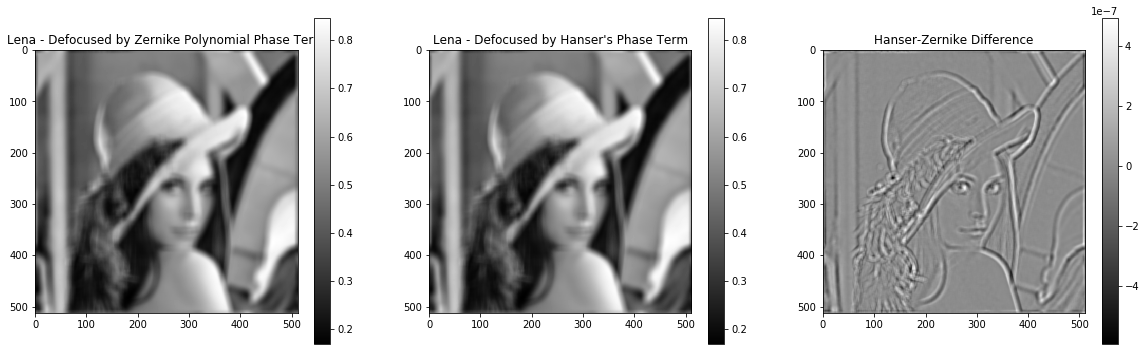

In [22]:
fig = plt.figure(figsize=(20,6))
fig.add_subplot(131)
ax = plt.imshow(np.abs(imageZernikeDefocus), cmap='gray')
plt.title("Lena - Defocused by Zernike Polynomial Phase Term")
plt.colorbar(ax)
fig.add_subplot(132)
ax = plt.imshow(np.abs(imageHanserDefocus), cmap='gray')
plt.title("Lena - Defocused by Hanser's Phase Term")
plt.colorbar(ax)
fig.add_subplot(133)
ax = plt.imshow(np.abs(imageHanserDefocus) - np.abs(imageZernikeDefocus), cmap='gray')
plt.title("Hanser-Zernike Difference")
plt.colorbar(ax)

print('rMSE between the two defocus models is {}'.format(np.sqrt(compare_mse(np.abs(imageHanserDefocus), np.abs(imageZernikeDefocus)))))

**An important note**: Zernike polynomials are shown to work under the paraxial approximation. For high NA systems, Hanser defocus model should be used. However, with Zernike polynomials we can add other aberrations such as astigmatism, coma, etc. ( [Wikipedia](https://en.wikipedia.org/wiki/Zernike_polynomials#Zernike_polynomials) has a list of which polynomial corresponds to which aberration)

Visually the two models are indistiungishable. Numerically, we can see that the differences are very close to zero, too. If we compare one of these two models with a basic "disk convolution" blur we get a relatively large root mse. The resultant images are visually different, and we can also see it in the difference map, too:

rMSE between the two defocus models is 0.01880483896526495


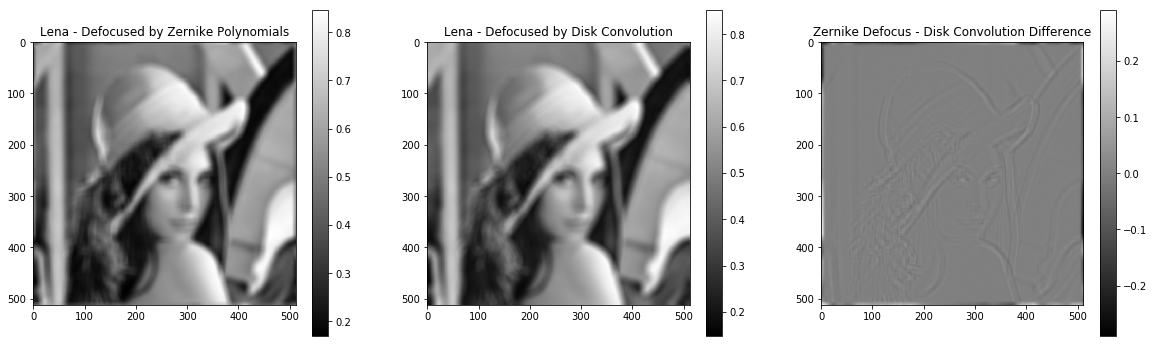

In [23]:
defocus = Defocuser(10, type_='disk')
blurred = defocus.apply(image)
#print('The root mse error between the original and disk-blurred (without noise) image is {}'.format(np.sqrt(compare_mse(np.abs(image), np.abs(blurred)))))

fig = plt.figure(figsize=(20,6))
fig.add_subplot(131)
ax = plt.imshow(np.abs(imageZernikeDefocus), cmap='gray')
plt.title("Lena - Defocused by Zernike Polynomials")
plt.colorbar(ax)
fig.add_subplot(132)
ax = plt.imshow(np.abs(blurred), cmap='gray')
plt.title("Lena - Defocused by Disk Convolution")
plt.colorbar(ax)
fig.add_subplot(133)
ax = plt.imshow(np.abs(imageZernikeDefocus) - np.abs(blurred), cmap='gray')
plt.title("Zernike Defocus - Disk Convolution Difference")
plt.colorbar(ax)

print('rMSE between the two defocus models is {}'.format(np.sqrt(compare_mse(np.abs(blurred), np.abs(imageZernikeDefocus)))))

## A Naive Approach to Correcting the Defocus Blur

Assuming we know the defocus psf, we may try to "deconvolve" with that same psf to go back to the original, in-focus image. In frequency domain ( $\otimes$ is elementwise multiplication);

$$ G(fx,fy) = Im(x,y) \otimes H(fx,fy) $$
$$ Im(fx,fy) = G(fx,fy)  \otimes  \frac{1}{H(fx,fy)} $$

In the implementation below, note that I have added an $epsilon$ term to the H (in fact, we should call this the optical transfer function since it is the fourier transform of the psf) for both $conv2$ and $deconv2$ functions. This is because the PSF has some 0 elements and we don't want $Inf$ values after the division:

In [24]:
epsilon = 1e-4

def deconv2_eps(g1, g2, dx):
    # Switch to frequency domain and multiply, a.k.a. convolution theorem
    G1 = ft2(g1, dx)
    G2 = ft2(g2, dx) + epsilon
    G_out = G1/G2 
    # Instead of passing numPixels as a parameter, just read it from the input size
    numPixels = g1.shape[0]    
    # Switch back to the spatial domain
    # Note that 1/(numPixels*dx) is equal to df (or 1/L)
    g_out = ift2(G_out, 1/(numPixels*dx))
    return g_out

def conv2_eps(g1, g2, dx):
    # Switch to frequency domain and multiply, a.k.a. convolution theorem
    G1 = ft2(g1, dx)
    G2 = ft2(g2, dx) + epsilon
    G_out = G1*G2
    # Instead of passing numPixels as a parameter, just read it from the input size
    numPixels = g1.shape[0]    
    # Switch back to the spatial domain
    # Note that 1/(numPixels*dx) is equal to df (or 1/L)
    g_out = ift2(G_out, 1/(numPixels*dx))
    return g_out

This simple division idea has a big flow: The values of PSF very close to zero will amplify corresponding frequencies in the deconvolution step. If we don't have any noise (noise spans a lot of frequencies) this is not much of a problem but in case of noise, our naive deconvolution will amplify the noise frequencies so much that we will recover only the noise:

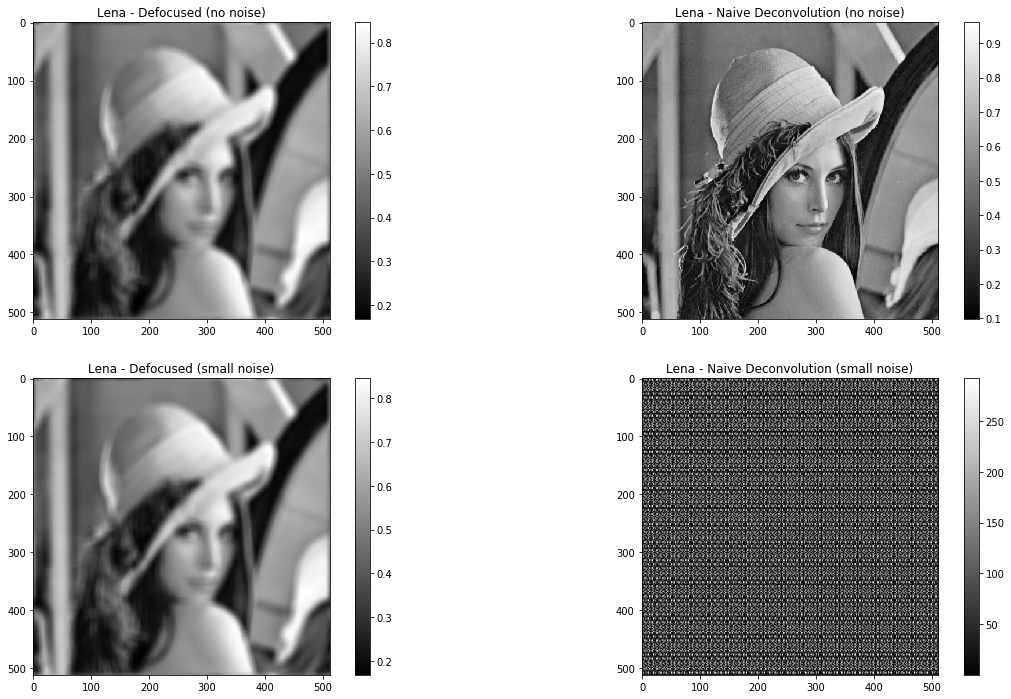

In [25]:
pupil = createPupil(L, numPixels, pupilRadius)
h = ft2(pupil* defocusTerm, dx)
blur_psf = np.abs(h)**2

blurred = conv2_eps(image, blur_psf, df)
deblurredNaive = deconv2_eps(blurred, blur_psf, df)

noise_std = 1e-4
noise = np.random.normal(0, noise_std, image.shape)
blurredNoisy = blurred + noise
deblurredNaiveNoisy = deconv2_eps(blurredNoisy, blur_psf, df)


fig = plt.figure(figsize=(20,12))
fig.add_subplot(221)
ax = plt.imshow(np.abs(blurred), cmap='gray')
plt.title("Lena - Defocused (no noise)")
plt.colorbar(ax)

fig.add_subplot(222)
ax = plt.imshow(np.abs(deblurredNaive), cmap='gray')
plt.title("Lena - Naive Deconvolution (no noise)")
plt.colorbar(ax)

fig.add_subplot(223)
ax = plt.imshow(np.abs(blurredNoisy), cmap='gray')
plt.title("Lena - Defocused (small noise)")
plt.colorbar(ax)

fig.add_subplot(224)
ax = plt.imshow(np.abs(deblurredNaiveNoisy), cmap='gray')
plt.title("Lena - Naive Deconvolution (small noise)")
plt.colorbar(ax);

## Wiener Filtering

Wikipedia has a good [interpretation](https://en.wikipedia.org/wiki/Wiener_deconvolution#Interpretation) of the Wiener filtering operation:

\begin{align}
 W(f) & = \frac{1}{H(f)} \left[ \frac{ |H(f)|^2 }{ |H(f)|^2 + \frac{N(f)}{S(f)} } \right] \\
      & = \frac{1}{H(f)} \left[ \frac{ |H(f)|^2 }{ |H(f)|^2 + \frac{1}{\mathrm{SNR}(f)}} \right]
\end{align}

This means that the Wiener filter penalizes the frequencies with low SNR. As a result, we calculate a deblurred image where the frequencies of the noise signal is damped. 

Generally, we do not know the power spectrum of the original signal. However, the thing about power spectrums is:
- Noise tend to span all frequencies,
- Signal power spectrums usually look very similar to each other. (e.g., natural scenes have a similar level of "fine" and "coarse" elements)

As a result, estimation would not give the best possible result (which corresponds to the known SNR case) but it would be acceptable.

In [26]:
def wiener2(blurredNoisy, blur_psf, dx, NSR):
    G1 = ft2(blurredNoisy, dx)
    G2 = ft2(blur_psf, dx)

    G_out = G1 * (1/G2)*(np.abs(G2)**2)/((np.abs(G2)**2) + NSR)
    deblurred = ift2(G_out, 1/(numPixels*dx))
    return deblurred

In [27]:
blurred = conv2_eps(image, blur_psf, df)

noise_std = 1e-4
noise = np.random.normal(0, noise_std, image.shape)
blurredNoisy = blurred + noise

# For Poisson noise instead of Gaussian, comment the above three lines and uncomment the three lines below
#poisson_val = 1e-8
#blurredNoisy = np.random.poisson(np.abs(blurred) / poisson_val) * poisson_val
#noise = np.abs(blurred) - np.abs(blurredNoisy)

Pnn = np.abs(fftshift(fft2(noise)))**2
Pss = np.abs(fftshift(fft2(image)))**2
NSR = Pnn/Pss

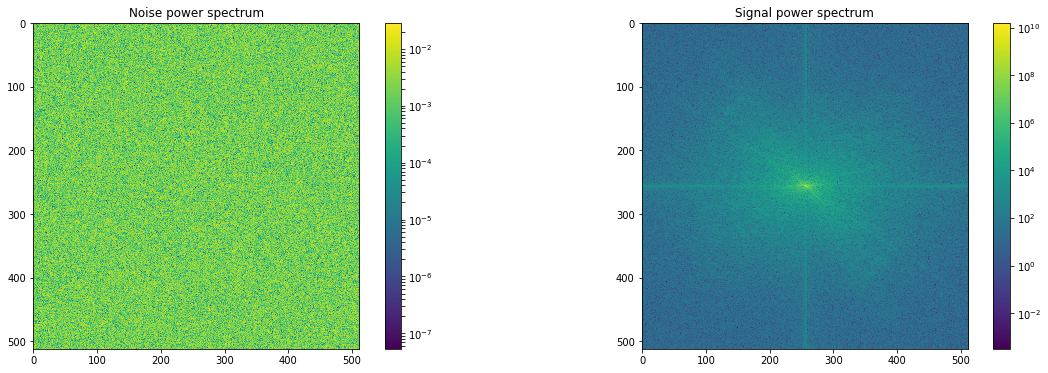

In [28]:
fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
ax = plt.imshow(Pnn, norm=colors.LogNorm(vmin=Pnn.min(), vmax=Pnn.max()))
plt.colorbar(ax)
plt.title("Noise power spectrum")

fig.add_subplot(122)
ax = plt.imshow(Pss, norm=colors.LogNorm(vmin=Pss.min(), vmax=Pss.max()))
plt.colorbar(ax)
plt.title("Signal power spectrum");

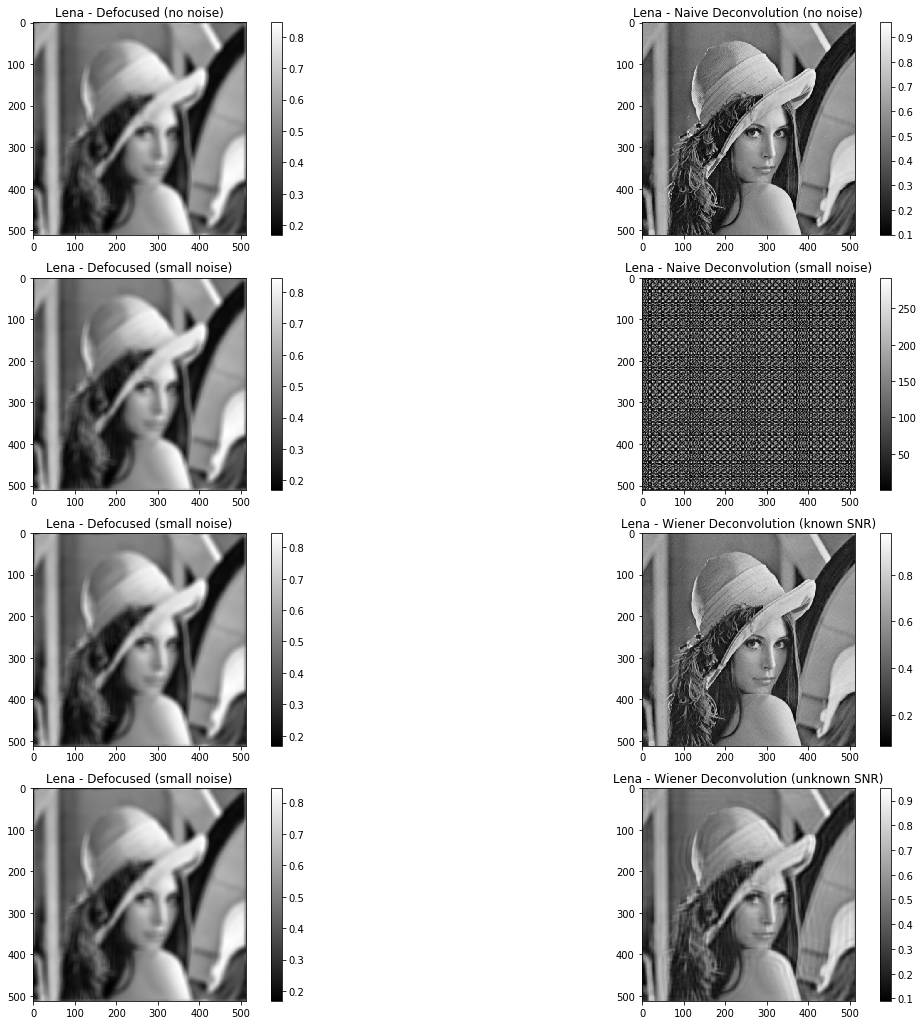

In [33]:
deblurredWiener_Known_SNR = wiener2(blurredNoisy, blur_psf, df, NSR)
deblurredWiener_Unknown_SNR = wiener2(blurredNoisy, blur_psf, df, 1e-2)

fig = plt.figure(figsize=(20,18))
fig.add_subplot(421)
ax = plt.imshow(np.abs(blurred), cmap='gray')
plt.title("Lena - Defocused (no noise)")
plt.colorbar(ax)

fig.add_subplot(422)
ax = plt.imshow(np.abs(deblurredNaive), cmap='gray')
plt.title("Lena - Naive Deconvolution (no noise)")
plt.colorbar(ax)

fig.add_subplot(423)
ax = plt.imshow(np.abs(blurredNoisy), cmap='gray')
plt.title("Lena - Defocused (small noise)")
plt.colorbar(ax)

fig.add_subplot(424)
ax = plt.imshow(np.abs(deblurredNaiveNoisy), cmap='gray')
plt.title("Lena - Naive Deconvolution (small noise)")
plt.colorbar(ax);

fig.add_subplot(425)
ax = plt.imshow(np.abs(blurredNoisy), cmap='gray')
plt.title("Lena - Defocused (small noise)")
plt.colorbar(ax)

fig.add_subplot(426)
ax = plt.imshow(np.abs(deblurredWiener_Known_SNR), cmap='gray')
plt.title("Lena - Wiener Deconvolution (known SNR)")
plt.colorbar(ax);

fig.add_subplot(427)
ax = plt.imshow(np.abs(blurredNoisy), cmap='gray')
plt.title("Lena - Defocused (small noise)")
plt.colorbar(ax)

fig.add_subplot(428)
ax = plt.imshow(np.abs(deblurredWiener_Unknown_SNR), cmap='gray')
plt.title("Lena - Wiener Deconvolution (unknown SNR)")
plt.colorbar(ax);
fig.savefig('images/wiener_comparison.png')

Note that we have selected a very small noise variance - with stronger noise the performance of the technique will be worse.

## Richardson-Lucy Algorithm

Richardson-Lucy is a variation of the Expectation Maximization algorithm. This is an iterative algorithm where we start with an initial estimate, $f_{(0)}$, and iteratively update this estimate to get a deblurred $f_{(k)}$ at the $k^{th}$ iteration. The algorithm can be written as:

$$f_{(k+1)} = f_{(k)}.H^T * \frac{g}{H * f_{k}}$$

where, $f_{(k)}$ is the current deblur estimate ( $f_{(0)}$ is usually selected as the blurred input image), $H$ is the known point spread function, $g$ is the input. Here, $*$ denotes convolution operation while the $.$ and fraction are elementwise multiplication and division operations respectively.

There are a lot of different derivations of the Richardson-Lucy algorithm. I would suggest the one in chapter 7.3 of [Bertero, M., Boccacci, P. (1998). Introduction to Inverse Problems in Imaging. Boca Raton: CRC Press.](https://www.taylorfrancis.com/books/9781439822067).

In [30]:
def richardsonLucy(img, psf, iterations=100):
    f = img
    blur_psf = np.matrix(psf)
    # the next line should the adjoint of the psf, that is the conjugate transpose. Here, since our psf is already real I used standard transpose:
    psf_mirror = blur_psf.T

    for _ in range(iterations):
        # Implementation of the above update rule:
        f = f * conv2(img / conv2(f, blur_psf, df), psf_mirror, df)
        # Enforce reasonable values:
        f[np.abs(f)>1] = 1+0j
        f[np.abs(f)<0] = 0+0j
    
    return f

In [31]:
pupilRadius = 0.1
z = 0.60221

X,Y = np.meshgrid(x,x)
r, theta = cart2pol(X, Y)
W = z * zernike(2, 0, 2*r/pupilRadius, theta)
defocusTerm = np.exp(1j * 2*np.pi * W)

pupil = createPupil(L, numPixels, pupilRadius)
h = ft2(pupil* defocusTerm, dx)
psf = np.abs(h)**2

blurred = conv2_eps(image, psf, df)

poisson_val = 1e-8
blurredNoisy = np.random.poisson(np.abs(blurred) / poisson_val) * poisson_val

# For additive Gaussian noise, comment the preceding two lines and uncomment the following three
#noise_std = 1e-4
#noise = np.random.normal(0, noise_std, image.shape)
#blurredNoisy = blurred + noise

deblurredRL = richardsonLucy(blurredNoisy, psf, iterations=100)

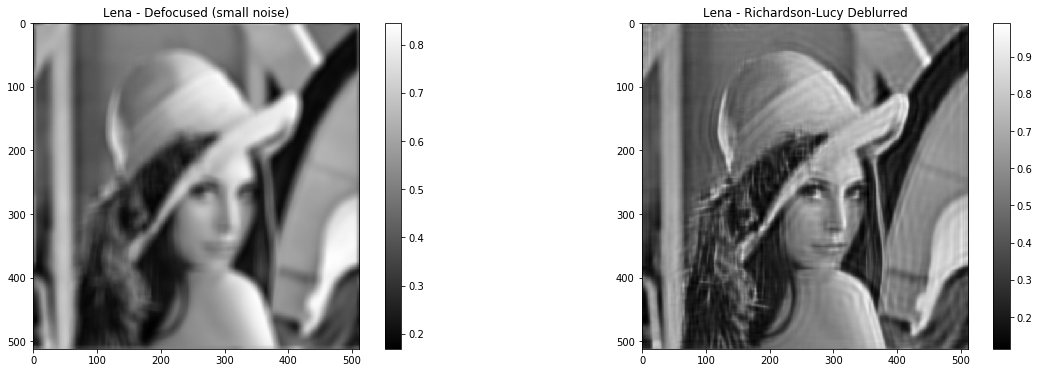

In [32]:
fig = plt.figure(figsize=(20,6))
fig.add_subplot(121)
ax = plt.imshow(np.abs(blurredNoisy), cmap='gray')
plt.title("Lena - Defocused (small noise)")
plt.colorbar(ax)

fig.add_subplot(122)
ax = plt.imshow(np.abs(deblurredRL), cmap='gray')
plt.title("Lena - Richardson-Lucy Deblurred")
plt.colorbar(ax);